In [1]:
# Reading PDFs
from langchain_community.document_loaders import PyPDFLoader
from langchain_unstructured import UnstructuredLoader
from langchain_core.documents import Document

# Embeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings

# Chat Models
from langchain_huggingface import ChatHuggingFace, HuggingFacePipeline
from langchain_ollama import ChatOllama

# Chat structure
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages

# Typing
from typing import Optional, Callable, Dict, Any
from typing_extensions import Annotated, List, TypedDict
from pydantic import BaseModel, Field
from langchain.schema import HumanMessage, AIMessage, SystemMessage

%load_ext autoreload
%autoreload 2

### Load PDF

In [9]:
file_path = '../papers/examples/meteorite.pdf'

# Load as individual pages:
loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [10]:
# Load as chunks of parsed text
loader = UnstructuredLoader(
    file_path=file_path,
    strategy="hi_res"
)
chunks = []
for doc in loader.lazy_load():
    chunks.append(doc)

# Filter out metadata
filter_keys = ['category', 'page_number']
filtered_chunks = []

for d in chunks:
    mdata = {k: v for k,v in d.metadata.items() if k in filter_keys}
    fdoc = Document(page_content = d.page_content, metadata = mdata)
    filtered_chunks.append(fdoc)

INFO: Reading PDF for file: ../papers/examples/meteorite.pdf ...


In [11]:
# Full code and examples: 
# https://python.langchain.com/docs/how_to/document_loader_pdf/#extracting-tables-and-other-structures

import fitz
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image


def plot_pdf_with_boxes(pdf_page, segments):
    pix = pdf_page.get_pixmap()
    pil_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(pil_image)
    categories = set()
    category_to_color = {
        "Title": "orchid",
        "Image": "forestgreen",
        "Table": "tomato",
    }
    for segment in segments:
        points = segment["coordinates"]["points"]
        layout_width = segment["coordinates"]["layout_width"]
        layout_height = segment["coordinates"]["layout_height"]
        scaled_points = [
            (x * pix.width / layout_width, y * pix.height / layout_height)
            for x, y in points
        ]
        box_color = category_to_color.get(segment["category"], "deepskyblue")
        categories.add(segment["category"])
        rect = patches.Polygon(
            scaled_points, linewidth=1, edgecolor=box_color, facecolor="none"
        )
        ax.add_patch(rect)

    # Make legend
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]
    for category in ["Title", "Image", "Table"]:
        if category in categories:
            legend_handles.append(
                patches.Patch(color=category_to_color[category], label=category)
            )
    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
    plt.show()


def render_page(doc_list: list, page_number: int, print_text=True) -> None:
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    page_docs = [
        doc for doc in doc_list if doc.metadata.get("page_number") == page_number
    ]
    segments = [doc.metadata for doc in page_docs]
    plot_pdf_with_boxes(pdf_page, segments)
    if print_text:
        for doc in page_docs:
            print(f"{doc.page_content}\n")

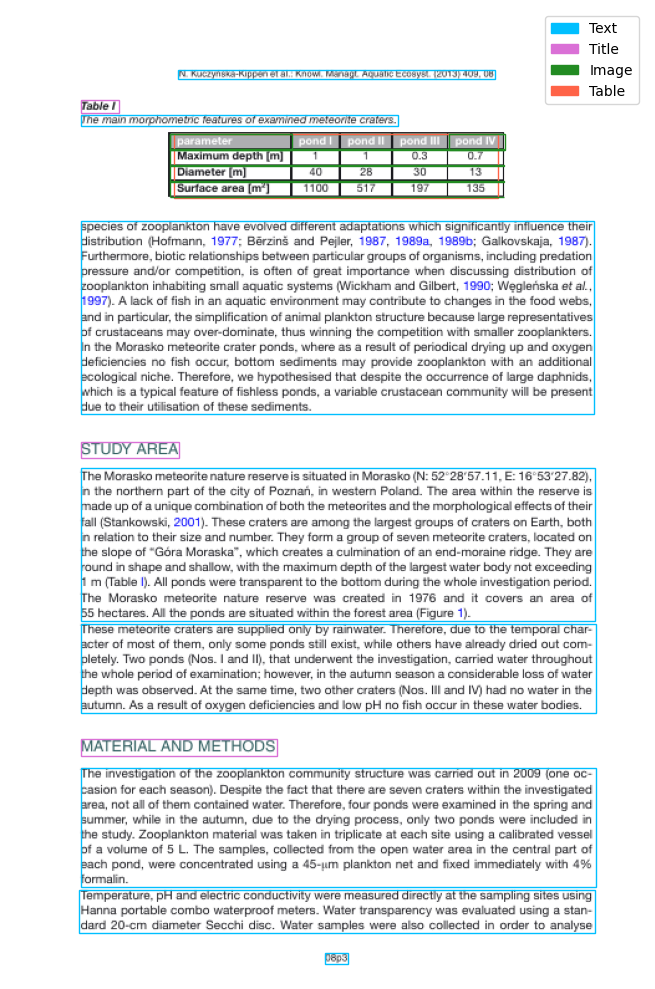

N. Kuczy´nska-Kippen et al.: Knowl. Managt. Aquatic Ecosyst. (2013) 409, 08

Table I

The main morphometric features of examined meteorite craters.



parameter pond I pond II pond III pond IV Maximum depth [m] 1 1 0.3 0.7 Diameter [m] 40 28 30 13 Surface area [m2] 1100 517 197 135



parameter 

pond IV 















species of zooplankton have evolved different adaptations which signiﬁcantly inﬂuence their distribution (Hofmann, 1977; B˜erzinš and Pejler, 1987, 1989a, 1989b; Galkovskaja, 1987). Furthermore, biotic relationships between particular groups of organisms, including predation pressure and/or competition, is often of great importance when discussing distribution of zooplankton inhabiting small aquatic systems (Wickham and Gilbert, 1990; W˛egle´nska et al., 1997). A lack of ﬁsh in an aquatic environment may contribute to changes in the food webs, and in particular, the simpliﬁcation of animal plankton structure because large representatives of crustaceans may over-dominate

In [12]:
render_page(chunks, 3)

### Embeddings

In [13]:
embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/multilingual-e5-large-instruct",
    model_kwargs={'device': 'mps'},
    encode_kwargs={'normalize_embeddings': False}
)

page_store = InMemoryVectorStore(
    embedding=embeddings
)

_ = page_store.add_documents(documents=pages)


chunk_store = InMemoryVectorStore(
    embedding=embeddings
)

_ = chunk_store.add_documents(documents=filtered_chunks)

INFO: Load pretrained SentenceTransformer: intfloat/multilingual-e5-large-instruct


In [15]:
query = (
    "Data collected and reported for physical or chemical attributes of individually stuided ponds. "
    "Examples include but are not limited to depth, surface area, temperature, or pH."
)

In [16]:
# Retreive pages:
# NOTE: Depth seems to find the right page, but surface area does not. 
retreived = page_store.similarity_search(query = query, k = 5)
print(retreived[0].page_content)

N. Kuczy´nska-Kippen et al.: Knowl. Managt. Aquatic Ecosyst. (2013)409, 08
Table II
Descriptive data on zooplankton community structure and physical-chemical parameters in particular
seasons and in certain crater.
pond No.
 I
 I
 I
 II
 II
 II
 III
 III
 IV
 IV
Parameter
 spring
 summer
 autumn
 spring
 summer
 autumn
 spring
 summer
 spring
 summer
Rotifera
density
 188
 555
 10150
 30
 34
 64
 560
 220
 48
 324
(ind L−1)
Rotifera
number
 4
 13
 13
 5
 11
 10
 7
 4
 8
 13
of species
Cladocera
density
 3
 316
 60
 10
 120
 99
 25
 299
 3
 39
(ind L−1)
Cladocera
number
 3
 11
 8
 7
 9
 5
 7
 11
 3
 9
of species
Copepoda
density
 18
 23
 2
 12
 1
 1
 1
 3
 25
 3
(ind L−1)
Copepoda
number
 2
 3
 1
 4
 1
 1
 1
 1
 4
 2
of species
Rotifera
 0.17
 1.51
 0.46
 0.74
 1.94
 0.97
 0.57
 0.6
 0.96
 1.32
Shannon
Crustacea
 0.44
 1.59
 1.07
 1.87
 1.2
 0.28
 1.56
 1.07
 0.78
 1.69
Shannon
DIN (mg·L−1)
 9.197
 7.334
 7.695
 6.824
 8.481
 8.719
 6.534
 5.19
 19.287
 24.984
TP (mg·L−1)
 1.23
 1.41
 1.

In [17]:
# Retreive chunks:
retreived = chunk_store.similarity_search(query = query, k = 10)
print(retreived[0].page_content)

Descriptive data on zooplankton community structure and physical-chemical parameters in particular seasons and in certain crater.


### Gemini

In [18]:
gemini = ChatOllama(
    model="gemma3:12b-it-qat",
    temperature=0
)

### Bloom

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-7b1")
model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-7b1")

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=100,
    top_k=50,
    temperature=0.1
)
bloom = HuggingFacePipeline(pipeline=pipe)
bloom.invoke("Hugging Face is")
bloom_engine_hf = ChatHuggingFace(llm=bloom)
bloom_engine_hf.invoke("Hugging Face is")

### Chat

In [ ]:
class StructuredResponse(BaseModel):
    """
    Manages a structured response from a language model.
    """
    success : bool = Field(
        description = 
            "Respond with False for a negative or unknown answer. "
            "Respond True only if the question is answered affirmitavely. "
    )
    
    reason : str = Field(
        description = 
            "Point to a specific location or excerpt "
            "from the text to justify your reasoning. "
            "'None' if nothing extracted."
    )

In [31]:
llm = gemini 
llm = llm.with_structured_output(StructuredResponse)

instructions = (
        "You will be given contextual information from a scientific research paper "
        "and asked to accurately answer questions about its contents. "
        "If applicable, point to a specific location or excerpt "
        "from the text to justify your reasoning."
    )

prompt_template = ChatPromptTemplate([
    ("system", instructions),
    ("human", "Context : {context} \n\n Question : {prompt} \n\n Answer :"),
])

In [ ]:
class State(TypedDict):
    retrieval_query : str
    prompt : str
    context : List[Document]
    answer : StructuredResponse


def retrieve(state: State):
    retrieved_docs = page_store.similarity_search(state["retrieval_query"], k = 5)
    return {"context": retrieved_docs}


def generate(state: State):
    # For full document:
    #docs_content = "\n\n".join(doc.page_content for doc in pages)

    # For retrieved text:
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    
    messages = prompt_template.invoke({"prompt": state["prompt"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response}


# Compile application and test
graph_builder = StateGraph(State)
graph_builder.add_node("generate", generate)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()

In [33]:
retreival_query = (
    "Data collected and reported for physical or chemical attributes of individually stuided ponds. "
    "Examples include but are not limited to depth, surface area, temperature, or pH."
)
prompt = (
    "Does the paper report data related to physical or chemical attributes of individual ponds? "
    "Examples include but are not limited to depth, surface area, temperature, or pH. "
    "Give reasoning and textual evidence to support your conclusion."
)
output = graph.invoke({"retrieval_query": query, "prompt" : prompt})

INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


In [36]:
print(output['answer'].reason)

Yes, the paper reports data related to physical and chemical attributes of individual ponds, although not always explicitly linked to individual pond identifiers. The paper consistently reports average values for the entire study, but also mentions variations and trends observed across the ponds and seasons. Here's the textual evidence:

*   **Physical Attributes:** The paper mentions depth and surface area indirectly through the description of the ponds as 'meteorite crater ponds' which implies a certain physical structure. The temporary nature of some ponds (drying out in autumn) also speaks to their physical characteristics and water level fluctuations.
*   **Chemical Attributes:** The paper extensively reports on chemical attributes, including:
    *   **pH:** “The four examined meteorite crater ponds were characterised by a light acidic to neutral reactivity of the water (mean 6.77 ±0.31, irrespective of pond and season).”
    *   **Conductivity:** “Conductivity was at a similar l

In [37]:
retrieval_query = (
    "Scientific definitions for ponds specifying distinguishing physical or chemical attributes."
)
prompt = (
    "Does the paper contain a concrete, scientific definition for a pond? "
    "A definition should specify distinguishing physical or chemical attributes. "
    "Give reasoning or textual evidence to support your conclusion."
)
output = graph.invoke({"retrieval_query": retrieval_query, "prompt" : prompt})

INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


In [39]:
print(output['answer'])

success=False reason="The paper does not contain a concrete, scientific definition for a pond. It consistently refers to the water bodies as 'ponds' or 'small water bodies' without specifying any distinguishing physical or chemical attributes that define a pond. There's no mention of depth, surface area, permanence, or any other criteria that would constitute a formal definition."
